<a href="https://colab.research.google.com/github/StevenBryceLee/DS-Unit-2-Linear-Models/blob/master/module3-ridge-regression/Copy_of_LS_DS_213_assignment.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Lambda School Data Science

*Unit 2, Sprint 1, Module 3*

---

# Ridge Regression

## Assignment

We're going back to our other **New York City** real estate dataset. Instead of predicting apartment rents, you'll predict property sales prices.

But not just for condos in Tribeca...

- [ ] Use a subset of the data where `BUILDING_CLASS_CATEGORY` == `'01 ONE FAMILY DWELLINGS'` and the sale price was more than 100 thousand and less than 2 million.
- [ ] Do train/test split. Use data from January — March 2019 to train. Use data from April 2019 to test.
- [ ] Do one-hot encoding of categorical features.
- [ ] Do feature selection with `SelectKBest`.
- [ ] Fit a ridge regression model with multiple features. Use the `normalize=True` parameter (or do [feature scaling](https://scikit-learn.org/stable/modules/preprocessing.html) beforehand — use the scaler's `fit_transform` method with the train set, and the scaler's `transform` method with the test set)
- [ ] Get mean absolute error for the test set.
- [ ] As always, commit your notebook to your fork of the GitHub repo.

The [NYC Department of Finance](https://www1.nyc.gov/site/finance/taxes/property-rolling-sales-data.page) has a glossary of property sales terms and NYC Building Class Code Descriptions. The data comes from the [NYC OpenData](https://data.cityofnewyork.us/browse?q=NYC%20calendar%20sales) portal.


## Stretch Goals

Don't worry, you aren't expected to do all these stretch goals! These are just ideas to consider and choose from.

- [ ] Add your own stretch goal(s) !
- [ ] Instead of `Ridge`, try `LinearRegression`. Depending on how many features you select, your errors will probably blow up! 💥
- [ ] Instead of `Ridge`, try [`RidgeCV`](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.RidgeCV.html).
- [ ] Learn more about feature selection:
    - ["Permutation importance"](https://www.kaggle.com/dansbecker/permutation-importance)
    - [scikit-learn's User Guide for Feature Selection](https://scikit-learn.org/stable/modules/feature_selection.html)
    - [mlxtend](http://rasbt.github.io/mlxtend/) library
    - scikit-learn-contrib libraries: [boruta_py](https://github.com/scikit-learn-contrib/boruta_py) & [stability-selection](https://github.com/scikit-learn-contrib/stability-selection)
    - [_Feature Engineering and Selection_](http://www.feat.engineering/) by Kuhn & Johnson.
- [ ] Try [statsmodels](https://www.statsmodels.org/stable/index.html) if you’re interested in more inferential statistical approach to linear regression and feature selection, looking at p values and 95% confidence intervals for the coefficients.
- [ ] Read [_An Introduction to Statistical Learning_](http://faculty.marshall.usc.edu/gareth-james/ISL/ISLR%20Seventh%20Printing.pdf), Chapters 1-3, for more math & theory, but in an accessible, readable way.
- [ ] Try [scikit-learn pipelines](https://scikit-learn.org/stable/modules/compose.html).

In [87]:
%%capture
import sys

# If you're on Colab:
if 'google.colab' in sys.modules:
    DATA_PATH = 'https://raw.githubusercontent.com/LambdaSchool/DS-Unit-2-Applied-Modeling/master/data/'
    !pip install category_encoders==2.*

# If you're working locally:
else:
    DATA_PATH = '../data/'
    
# Ignore this Numpy warning when using Plotly Express:
# FutureWarning: Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.
import warnings
warnings.filterwarnings(action='ignore', category=FutureWarning, module='numpy')

In [88]:
import pandas as pd
import pandas_profiling

# Read New York City property sales data
df = pd.read_csv(DATA_PATH+'condos/NYC_Citywide_Rolling_Calendar_Sales.csv')

# Change column names: replace spaces with underscores
df.columns = [col.replace(' ', '_') for col in df]

# SALE_PRICE was read as strings.
# Remove symbols, convert to integer
df['SALE_PRICE'] = (
    df['SALE_PRICE']
    .str.replace('$','')
    .str.replace('-','')
    .str.replace(',','')
    .astype(int)
)

In [89]:
# BOROUGH is a numeric column, but arguably should be a categorical feature,
# so convert it from a number to a string
df['BOROUGH'] = df['BOROUGH'].astype(str)

In [90]:
# Reduce cardinality for NEIGHBORHOOD feature

# Get a list of the top 10 neighborhoods
top10 = df['NEIGHBORHOOD'].value_counts()[:10].index

# At locations where the neighborhood is NOT in the top 10, 
# replace the neighborhood with 'OTHER'
df.loc[~df['NEIGHBORHOOD'].isin(top10), 'NEIGHBORHOOD'] = 'OTHER'

###Use a subset of the data where BUILDING_CLASS_CATEGORY == '01 ONE FAMILY DWELLINGS' and the sale price was more than 100 thousand and less than 2 million.

In [91]:
df.head()

,BOROUGH,NEIGHBORHOOD,BUILDING_CLASS_CATEGORY,TAX_CLASS_AT_PRESENT,BLOCK,LOT,EASE-MENT,BUILDING_CLASS_AT_PRESENT,ADDRESS,APARTMENT_NUMBER,ZIP_CODE,RESIDENTIAL_UNITS,COMMERCIAL_UNITS,TOTAL_UNITS,LAND_SQUARE_FEET,GROSS_SQUARE_FEET,YEAR_BUILT,TAX_CLASS_AT_TIME_OF_SALE,BUILDING_CLASS_AT_TIME_OF_SALE,SALE_PRICE,SALE_DATE
0,1,OTHER,13 CONDOS - ELEVATOR APARTMENTS,2,716,1246,NaN,R4,"447 WEST 18TH STREET, PH12A",PH12A,10011.0,1.0,0.0,1.0,"10,733",1979.0,2007.0,2,R4,0,01/01/2019
1,1,OTHER,21 OFFICE BUILDINGS,4,812,68,NaN,O5,144 WEST 37TH STREET,NaN,10018.0,0.0,6.0,6.0,"2,962",15435.0,1920.0,4,O5,0,01/01/2019
2,1,OTHER,21 OFFICE BUILDINGS,4,839,69,NaN,O5,40 WEST 38TH STREET,NaN,10018.0,0.0,7.0,7.0,"2,074",11332.0,1930.0,4,O5,0,01/01/2019
3,1,OTHER,13 CONDOS - ELEVATOR APARTMENTS,2,592,1041,NaN,R4,"1 SHERIDAN SQUARE, 8C",8C,10014.0,1.0,0.0,1.0,0,500.0,0.0,2,R4,0,01/01/2019
4,1,UPPER EAST SIDE (59-79),15 CONDOS - 2-10 UNIT RESIDENTIAL,2C,1379,1402,NaN,R1,"20 EAST 65TH STREET, B",B,10065.0,1.0,0.0,1.0,0,6406.0,0.0,2,R1,0,01/01/2019


In [92]:
#Ease-ment did not come into the DF, therefore dropping
df = df.drop('EASE-MENT',axis = 1,inplace=False)
#Apartment number is highly variable with a ton of NaNs, replacing with categorical
df.APARTMENT_NUMBER = df.APARTMENT_NUMBER.fillna(0)
#df.drop('APARTMENT',axis = 1,inplace=True)
#Dealing with NaNs by interpolating, then filling the rest with nearest value
df = df.interpolate().ffill().bfill()

df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 23040 entries, 0 to 23039
Data columns (total 20 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   BOROUGH                         23040 non-null  object 
 1   NEIGHBORHOOD                    23040 non-null  object 
 2   BUILDING_CLASS_CATEGORY         23040 non-null  object 
 3   TAX_CLASS_AT_PRESENT            23040 non-null  object 
 4   BLOCK                           23040 non-null  int64  
 5   LOT                             23040 non-null  int64  
 6   BUILDING_CLASS_AT_PRESENT       23040 non-null  object 
 7   ADDRESS                         23040 non-null  object 
 8   APARTMENT_NUMBER                23040 non-null  object 
 9   ZIP_CODE                        23040 non-null  float64
 10  RESIDENTIAL_UNITS               23040 non-null  float64
 11  COMMERCIAL_UNITS                23040 non-null  float64
 12  TOTAL_UNITS                     

In [93]:
fam = df[(df['BUILDING_CLASS_CATEGORY'] == '01 ONE FAMILY DWELLINGS') & 
         (df['SALE_PRICE'] > 100000) & (df['SALE_PRICE'] < 2000000)].reset_index(drop = True).sort_values('SALE_DATE')
fam.head()

,BOROUGH,NEIGHBORHOOD,BUILDING_CLASS_CATEGORY,TAX_CLASS_AT_PRESENT,BLOCK,LOT,BUILDING_CLASS_AT_PRESENT,ADDRESS,APARTMENT_NUMBER,ZIP_CODE,RESIDENTIAL_UNITS,COMMERCIAL_UNITS,TOTAL_UNITS,LAND_SQUARE_FEET,GROSS_SQUARE_FEET,YEAR_BUILT,TAX_CLASS_AT_TIME_OF_SALE,BUILDING_CLASS_AT_TIME_OF_SALE,SALE_PRICE,SALE_DATE
0,3,OTHER,01 ONE FAMILY DWELLINGS,1,5495,801,A9,4832 BAY PARKWAY,0,11230.0,1.0,0.0,1.0,"6,800",1325.0,1930.0,1,A9,550000,01/01/2019
1,4,OTHER,01 ONE FAMILY DWELLINGS,1,7918,72,A1,80-23 232ND STREET,0,11427.0,1.0,0.0,1.0,"4,000",2001.0,1940.0,1,A1,200000,01/01/2019
22,5,OTHER,01 ONE FAMILY DWELLINGS,1,1448,1,A2,479 MAINE AVENUE,0,10314.0,1.0,0.0,1.0,"3,920",1850.0,1974.0,1,A2,670000,01/02/2019
20,5,OTHER,01 ONE FAMILY DWELLINGS,1,5442,145,A9,257 DOANE AVENUE,0,10308.0,1.0,0.0,1.0,"2,500",1392.0,1977.0,1,A9,505000,01/02/2019
19,5,OTHER,01 ONE FAMILY DWELLINGS,1,5708,35,A2,17 RATHBUN AVENUE,0,10312.0,1.0,0.0,1.0,"4,000",2278.0,1970.0,1,A2,552000,01/02/2019


### Do train/test split. Use data from January — March 2019 to train. Use data from April 2019 to test.
 

In [160]:
fam.LAND_SQUARE_FEET = fam.LAND_SQUARE_FEET.apply(lambda x: int( x.replace(',','')))

In [167]:
from datetime import datetime
date_from_start = pd.to_datetime(fam['SALE_DATE']).dt.date - pd.to_datetime(fam['SALE_DATE']).dt.date.min()
fam['day_count'] = date_from_start.apply(lambda x: x.days)

In [161]:
cutoff = '03/31/2019'
train = fam[fam.SALE_DATE <= cutoff]
test = fam[fam.SALE_DATE > cutoff]

In [161]:
from datetime import datetime
date_from_start = pd.to_datetime(fam.SALE_DATE.dt.date - pd.to_datetime(fam.SALE_DATE).dt.date.min()

In [193]:
X_train = train.drop(['ADDRESS','APARTMENT_NUMBER','SALE_DATE','SALE_PRICE'], axis=1)
y_train = train.SALE_PRICE
X_val = test.drop(['ADDRESS','APARTMENT_NUMBER','SALE_DATE','SALE_PRICE'], axis=1)
y_val = test.SALE_PRICE

###Do one-hot encoding of categorical features.
 

In [194]:
#In pandas
cate_cols = df.describe(include='object').columns
train_pd = pd.get_dummies(train,columns = cate_cols,drop_first=True)
test_pd = pd.get_dummies(test,columns = cate_cols,drop_first=True)

In [204]:
#In sklearn
cate_cols = ['BOROUGH','NEIGHBORHOOD','BUILDING_CLASS_CATEGORY','TAX_CLASS_AT_PRESENT',
             'BUILDING_CLASS_AT_PRESENT','BUILDING_CLASS_AT_TIME_OF_SALE']
from category_encoders import OneHotEncoder
ohe = OneHotEncoder(use_cat_names=True,cols = cate_cols)
XT_train = ohe.fit_transform(X_train)
XT_val = ohe.transform(X_val)

In [205]:
XT_val.head(2)

,BOROUGH_3,BOROUGH_4,BOROUGH_5,BOROUGH_2,BOROUGH_1,NEIGHBORHOOD_OTHER,NEIGHBORHOOD_FLUSHING-NORTH,NEIGHBORHOOD_EAST NEW YORK,NEIGHBORHOOD_BEDFORD STUYVESANT,NEIGHBORHOOD_FOREST HILLS,NEIGHBORHOOD_BOROUGH PARK,NEIGHBORHOOD_ASTORIA,BUILDING_CLASS_CATEGORY_01 ONE FAMILY DWELLINGS,TAX_CLASS_AT_PRESENT_1,TAX_CLASS_AT_PRESENT_1D,BLOCK,LOT,BUILDING_CLASS_AT_PRESENT_A9,BUILDING_CLASS_AT_PRESENT_A1,BUILDING_CLASS_AT_PRESENT_A2,BUILDING_CLASS_AT_PRESENT_A5,BUILDING_CLASS_AT_PRESENT_A3,BUILDING_CLASS_AT_PRESENT_A0,BUILDING_CLASS_AT_PRESENT_S1,BUILDING_CLASS_AT_PRESENT_A6,BUILDING_CLASS_AT_PRESENT_A4,BUILDING_CLASS_AT_PRESENT_B2,BUILDING_CLASS_AT_PRESENT_A8,BUILDING_CLASS_AT_PRESENT_S0,BUILDING_CLASS_AT_PRESENT_B3,ZIP_CODE,RESIDENTIAL_UNITS,COMMERCIAL_UNITS,TOTAL_UNITS,LAND_SQUARE_FEET,GROSS_SQUARE_FEET,YEAR_BUILT,TAX_CLASS_AT_TIME_OF_SALE,BUILDING_CLASS_AT_TIME_OF_SALE_A9,BUILDING_CLASS_AT_TIME_OF_SALE_A1,BUILDING_CLASS_AT_TIME_OF_SALE_A2,BUILDING_CLASS_AT_TIME_OF_SALE_A5,BUILDING_CLASS_AT_TIME_OF_SALE_A3,BUILDING_CLASS_AT_TIME_OF_SALE_A0,BUILDING_CLASS_AT_TIME_OF_SALE_S1,BUILDING_CLASS_AT_TIME_OF_SALE_A6,BUILDING_CLASS_AT_TIME_OF_SALE_A4,BUILDING_CLASS_AT_TIME_OF_SALE_A8,BUILDING_CLASS_AT_TIME_OF_SALE_S0
2530,0,1,0,0,0,1,0,0,0,0,0,0,1,1,0,11255,35,0,0,0,0,0,1,0,0,0,0,0,0,0,11411.0,1.0,0.0,1.0,3800,1031.0,1950.0,1,0,0,0,0,0,1,0,0,0,0,0
2536,0,1,0,0,0,1,0,0,0,0,0,0,1,1,0,12175,37,0,1,0,0,0,0,0,0,0,0,0,0,0,11433.0,1.0,0.0,1.0,1875,1386.0,1925.0,1,0,1,0,0,0,0,0,0,0,0,0


###Do feature selection with SelectKBest.
 

In [234]:
from sklearn.feature_selection import SelectKBest as SKB
from sklearn.linear_model import LinearRegression
from sklearn.feature_selection import f_regression

#Now instantiating SKB object and looping to find features
kvals = list(range(1,len(X_train.columns) + 1))
r2_train_list = []
r2_val_list = []

for k in kvals:
  #Instantiate the transformer
  skb = SKB(f_regression,k = k)
  #Transform the trainer
  XTT_train = skb.fit_transform(XT_train,y_train)
  #Fit the model
  model = LinearRegression()
  model.fit(XTT_train, y_train)
  #Get the r2 for training data
  r2_train_list.append(model.score(XTT_train,y_train))

  #Get the r2 for validation data
  XTT_val = skb.transform(XT_val)
  model.fit(XTT_val, y_val)
  r2_val_list.append(model.score(XTT_val,y_val))
#r2listcomprehension = [model.score(SKB(k = k).fit_transform(XT_train,y_train),y_train) for k in kvals]
print(r2list)
print()
#print(r2listcomprehension)

[0.20649603503598504, 0.21864168863539457, 0.22309571513409965, 0.22309571513409965, 0.27935732277871284, 0.32483368649951416, 0.3442635381564762, 0.3443024452757887, 0.3528809318174719, 0.3791495948089242, 0.3891628695047631, 0.3899173978436026, 0.4363558179022683, 0.4506714847966967, 0.45067158224805554, 0.4506808100516407]



/usr/local/lib/python3.6/dist-packages/sklearn/feature_selection/_univariate_selection.py:299: RuntimeWarning: divide by zero encountered in true_divide
  corr /= X_norms
/usr/local/lib/python3.6/dist-packages/sklearn/feature_selection/_univariate_selection.py:304: RuntimeWarning: invalid value encountered in true_divide
  F = corr ** 2 / (1 - corr ** 2) * degrees_of_freedom
/usr/local/lib/python3.6/dist-packages/scipy/stats/_distn_infrastructure.py:903: RuntimeWarning: invalid value encountered in greater
  return (a < x) & (x < b)
/usr/local/lib/python3.6/dist-packages/scipy/stats/_distn_infrastructure.py:903: RuntimeWarning: invalid value encountered in less
  return (a < x) & (x < b)
/usr/local/lib/python3.6/dist-packages/scipy/stats/_distn_infrastructure.py:1912: RuntimeWarning: invalid value encountered in less_equal
  cond2 = cond0 & (x <= _a)
/usr/local/lib/python3.6/dist-packages/sklearn/feature_selection/_univariate_selection.py:299: RuntimeWarning: divide by zero encountered

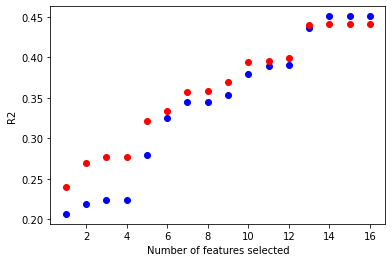

In [232]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
fig, ax = plt.subplots()
plt.scatter(kvals,r2_train_list, color = 'blue')
plt.scatter(kvals,r2_val_list, color = 'red')
ax.set_xlabel('Number of features selected')
ax.set_ylabel('R2')

plt.show();

In [207]:
X_train.head(2)

,BOROUGH,NEIGHBORHOOD,BUILDING_CLASS_CATEGORY,TAX_CLASS_AT_PRESENT,BLOCK,LOT,BUILDING_CLASS_AT_PRESENT,ZIP_CODE,RESIDENTIAL_UNITS,COMMERCIAL_UNITS,TOTAL_UNITS,LAND_SQUARE_FEET,GROSS_SQUARE_FEET,YEAR_BUILT,TAX_CLASS_AT_TIME_OF_SALE,BUILDING_CLASS_AT_TIME_OF_SALE
0,3,OTHER,01 ONE FAMILY DWELLINGS,1,5495,801,A9,11230.0,1.0,0.0,1.0,6800,1325.0,1930.0,1,A9
1,4,OTHER,01 ONE FAMILY DWELLINGS,1,7918,72,A1,11427.0,1.0,0.0,1.0,4000,2001.0,1940.0,1,A1


In [208]:
#Comparing to instructor code, getting the same errors
r2list = []
for k in kvals:
  # Instantiate Transformer 1
  ohe = OneHotEncoder(cols=cate_cols, use_cat_names=True)

  # Fit_transform 1
  XT_train = ohe.fit_transform(X_train)

  # Instantiate Transformer 2
  skb = SKB(k=10)

  # Fit_transform 2
  XTT_train = skb.fit_transform(XT_train, y_train)

  # Instantiate Predictor
  model = LinearRegression()

  # Fit on the DOUBLE-TRANSFORMED data
  model.fit(XTT_train, y_train)

  # Get R^2 score
  r2list.append(model.score(XTT_train, y_train))

/usr/local/lib/python3.6/dist-packages/sklearn/feature_selection/_univariate_selection.py:114: UserWarning: Features [ 4 12 28 29 37 48] are constant.
  UserWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/feature_selection/_univariate_selection.py:115: RuntimeWarning: divide by zero encountered in true_divide
  f = msb / msw
/usr/local/lib/python3.6/dist-packages/sklearn/feature_selection/_univariate_selection.py:115: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw
/usr/local/lib/python3.6/dist-packages/sklearn/feature_selection/_univariate_selection.py:114: UserWarning: Features [ 4 12 28 29 37 48] are constant.
  UserWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/feature_selection/_univariate_selection.py:115: RuntimeWarning: divide by zero encountered in true_divide
  f = msb / msw
/usr/local/lib/python3.6/dist-packages/sklearn/feature_selection/_univariate_selection.py:115: RuntimeWarning: invalid value encountered in true_divide
  f = msb 

In [209]:
#This is the treatment training data
X_train.head(2)

,BOROUGH,NEIGHBORHOOD,BUILDING_CLASS_CATEGORY,TAX_CLASS_AT_PRESENT,BLOCK,LOT,BUILDING_CLASS_AT_PRESENT,ZIP_CODE,RESIDENTIAL_UNITS,COMMERCIAL_UNITS,TOTAL_UNITS,LAND_SQUARE_FEET,GROSS_SQUARE_FEET,YEAR_BUILT,TAX_CLASS_AT_TIME_OF_SALE,BUILDING_CLASS_AT_TIME_OF_SALE
0,3,OTHER,01 ONE FAMILY DWELLINGS,1,5495,801,A9,11230.0,1.0,0.0,1.0,6800,1325.0,1930.0,1,A9
1,4,OTHER,01 ONE FAMILY DWELLINGS,1,7918,72,A1,11427.0,1.0,0.0,1.0,4000,2001.0,1940.0,1,A1


In [210]:
#This is the transformed treatment training data
XT_train.head(2)

,BOROUGH_3,BOROUGH_4,BOROUGH_5,BOROUGH_2,BOROUGH_1,NEIGHBORHOOD_OTHER,NEIGHBORHOOD_FLUSHING-NORTH,NEIGHBORHOOD_EAST NEW YORK,NEIGHBORHOOD_BEDFORD STUYVESANT,NEIGHBORHOOD_FOREST HILLS,NEIGHBORHOOD_BOROUGH PARK,NEIGHBORHOOD_ASTORIA,BUILDING_CLASS_CATEGORY_01 ONE FAMILY DWELLINGS,TAX_CLASS_AT_PRESENT_1,TAX_CLASS_AT_PRESENT_1D,BLOCK,LOT,BUILDING_CLASS_AT_PRESENT_A9,BUILDING_CLASS_AT_PRESENT_A1,BUILDING_CLASS_AT_PRESENT_A2,BUILDING_CLASS_AT_PRESENT_A5,BUILDING_CLASS_AT_PRESENT_A3,BUILDING_CLASS_AT_PRESENT_A0,BUILDING_CLASS_AT_PRESENT_S1,BUILDING_CLASS_AT_PRESENT_A6,BUILDING_CLASS_AT_PRESENT_A4,BUILDING_CLASS_AT_PRESENT_B2,BUILDING_CLASS_AT_PRESENT_A8,BUILDING_CLASS_AT_PRESENT_S0,BUILDING_CLASS_AT_PRESENT_B3,ZIP_CODE,RESIDENTIAL_UNITS,COMMERCIAL_UNITS,TOTAL_UNITS,LAND_SQUARE_FEET,GROSS_SQUARE_FEET,YEAR_BUILT,TAX_CLASS_AT_TIME_OF_SALE,BUILDING_CLASS_AT_TIME_OF_SALE_A9,BUILDING_CLASS_AT_TIME_OF_SALE_A1,BUILDING_CLASS_AT_TIME_OF_SALE_A2,BUILDING_CLASS_AT_TIME_OF_SALE_A5,BUILDING_CLASS_AT_TIME_OF_SALE_A3,BUILDING_CLASS_AT_TIME_OF_SALE_A0,BUILDING_CLASS_AT_TIME_OF_SALE_S1,BUILDING_CLASS_AT_TIME_OF_SALE_A6,BUILDING_CLASS_AT_TIME_OF_SALE_A4,BUILDING_CLASS_AT_TIME_OF_SALE_A8,BUILDING_CLASS_AT_TIME_OF_SALE_S0
0,1,0,0,0,0,1,0,0,0,0,0,0,1,1,0,5495,801,1,0,0,0,0,0,0,0,0,0,0,0,0,11230.0,1.0,0.0,1.0,6800,1325.0,1930.0,1,1,0,0,0,0,0,0,0,0,0,0
1,0,1,0,0,0,1,0,0,0,0,0,0,1,1,0,7918,72,0,1,0,0,0,0,0,0,0,0,0,0,0,11427.0,1.0,0.0,1.0,4000,2001.0,1940.0,1,0,1,0,0,0,0,0,0,0,0,0


Throwing a ton of errors. I think the reason that we see these is that A lot of my columns are 0 and 1, and have NaNs filled in them, although I see division by 0 warnings, which is odd

Resolved. I'm still getting errors, but the reason this wasn't working was because the default SKB function is used on categorical tasks, and we are doing a regression task so I need to import f_regression. Now, I'm getting good values for my r2 list

###Fit a ridge regression model with multiple features. Use the normalize=True parameter (or do feature scaling beforehand — use the scaler's fit_transform method with the train set, and the scaler's transform method with the test set)
 

In [227]:
from sklearn.linear_model import Ridge

model = Ridge(normalize = True)
model.fit(XTT_train,y_train)


Ridge(alpha=1.0, copy_X=True, fit_intercept=True, max_iter=None, normalize=True,
      random_state=None, solver='auto', tol=0.001)

###Get mean absolute error for the test set.


In [228]:
from sklearn.metrics import mean_absolute_error as MAE

y_pred = model.predict(XTT_val)
MAE(y_test,y_pred)

170718.93999282076

###Instead of Ridge, try LinearRegression. Depending on how many features you select, your errors will probably blow up! 💥

In [229]:
from sklearn.linear_model import LinearRegression
model = LinearRegression()
model.fit(XTT_train,y_train)
y_pred = model.predict(XTT_val)
MAE(y_test,y_pred)

157544.70256438744

###Instead of Ridge, try RidgeCV

In [230]:
from sklearn.linear_model import RidgeCV
model = RidgeCV()
model.fit(XTT_train,y_train)
y_pred = model.predict(XTT_val)
MAE(y_test,y_pred)

157492.50037021024

###Try scikit-learn pipelines.

In [235]:
from sklearn.pipeline import make_pipeline as MP
from sklearn.preprocessing import StandardScaler

pipe = MP(StandardScaler(),LinearRegression())


In [237]:
pipe.fit(XTT_train,y_train)
y_pred = pipe.predict(XTT_val)
MAE(y_val,y_pred)

157541.07816436957